# Building and Training Autoencoder 

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
from keras.layers import *
from tensorflow.keras.models import *

### Helper Function

In [3]:
def load_preprocess ():
    
    # load data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    
    # normalize data to range [0, 1]
    x_train = x_train / 255
    x_test = x_test / 255
    
    # reshape data for convolution layer
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)
    
    # labels are not needed as we are just working with the images
    return x_train, y_train, x_test, y_test

### Autoencoder Function

In [4]:
def autoencoder (train, test, batch_size, epochs):
    
    # define input, 28x28 input
    enc_inputs = Input(shape=(28, 28, 1))
    # convolution without padding and relu activation, 3x3 shapes
    enc_cov1 = Conv2D(48, (3, 3), activation = 'relu', padding = 'same')(enc_inputs)
    # convolution without padding and relu activation, 2x2 shapes
    enc_cov2 = Conv2D(24, (2, 2), activation = 'relu', padding = 'same')(enc_cov1)
    enc_pooling = MaxPooling2D((2, 2))(enc_cov2)
    enc_normalization = BatchNormalization()(enc_pooling)
    enc_cov3 = Conv2D(12, (2, 2), activation = 'relu', padding = 'same')(enc_normalization)
    # flatten the matrix
    enc_flat = Flatten()(enc_cov3)
    # force bottleneck by using 2 dense units to compress image
    enc_output = Dense(2, activation = 'relu')(enc_flat)
    encoder = Model(inputs = enc_inputs, outputs = enc_output)

    # define input, decoder will take the 2 dense units from encoder
    dec_inputs = Input(shape=(2,))
    # start reconstructing image with 4 dense units
    dec_dense1 = Dense(4, activation = 'relu')(dec_inputs)
    # further reconstructing image with 16 dense units
    dec_dense2 = Dense(16, activation = 'relu')(dec_dense1)
    # reshape flat vector to desired shape (2D)
    dec_reshape = Reshape((4, 4, 1))(dec_dense2)
    # upsample to get to desired output dimension (4x4 --> upscale 7 --> 28x28)
    dec_upsample = UpSampling2D((7, 7))(dec_reshape)
    # convolution wihtout padding and relu activation, 3x3 shapes to find image features
    dec_cov1 = Conv2D(24, (3, 3), activation = 'relu', padding = 'same')(dec_upsample)
    # output the 2D matrix with sigmoid activation
    dec_output = Dense(1, activation = 'sigmoid')(dec_cov1)
    decoder = Model(inputs = dec_inputs, outputs = dec_output)

    # encoder takes 28x28 image and output vector of length 2
    enc = encoder(enc_inputs)
    # decoder takes 2x1 vector and output 28x28 image
    dec = decoder(enc)

    auto_enc = Model(inputs = enc_inputs, outputs = dec)
    auto_enc.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['mse'])

    print(auto_enc.summary())

    history = auto_enc.fit(train, train, batch_size = batch_size, epochs = epochs, 
                           validation_data = (test, test))
    
    return encoder, decoder, auto_enc, history

In [6]:
x_train, y_train, x_test, y_test = load_preprocess()
encoder, decoder, auto_enc, history = autoencoder (x_train, x_test, 128, 5)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_3 (Functional)         (None, 2)                 11078     
_________________________________________________________________
model_4 (Functional)         (None, 28, 28, 1)         357       
Total params: 11,435
Trainable params: 11,387
Non-trainable params: 48
_________________________________________________________________
None
Epoch 1/5
469/469 [==============================] - 116s 246ms/step - loss: 0.5466 - mse: 0.1078 - val_loss: 0.4932 - val_mse: 0.0879
Epoch 2/5
469/469 [==============================] - 115s 245ms/step - loss: 0.4681 - mse: 0.0808 - val_loss: 0.4661 - val_mse: 0.0798
Epoch 3/5
469/469 [==============================] - 115s 245ms/step - loss: 0.4648 - mse: 0.0802 - val_loss:

### Training and Validation History

In [7]:
import pandas as pd

history = pd.DataFrame(history.history)
history

,loss,mse,val_loss,val_mse
0,0.502850,0.091927,0.493207,0.087942
1,0.466603,0.080491,0.466134,0.079814
2,0.463994,0.079845,0.464746,0.079440
3,0.462779,0.079522,0.463638,0.079101
4,0.461842,0.079237,0.464039,0.079031


### Auto Encoder Understanding
Autoencoders are an unsupervised learning technique for representation learning, in which neural networks are used to compress the representation of the input.

The neural network takes the original input, passes it through the network with the output of the network to be a dense layer with a small number of hidden units, creating a "bottleneck". In this example, the bottleneck forces the input to be reduced from a 28x28 image to a vector of length 2, i.e. the information from the 28x28 image is represented in a vector of length 2. Using the "same" padding hyperparameter, the output of each convolution uses zero-padding so that the output has the same size as the input. This first step is called encoding.

Once the input is represented in a lower dimension, the representation is fed to another network, which reconstrucs the input. The reconstruction of the input is done by building up the dimensions again using dense layers and upsampling. In this example, from the vector of length 2 output by the encoding, first a dense layer is generated to get enough hidden units to reshape the vector, e.g. 4 units to reshape to 2x2, 16 units to reshape to 4x4, 32 units to reshape to 8x8, etc. After the reshape is done, the reshaped matrix is oversampled to produce the 28x28 image. The 1 convolution layer in the decoder helps find some features in the reconstructed image and then the 28x28 image is outputted. This second step is called decoding.

In the code above, 3 convolutional layers in the encoder and 1 convolutional layer in the decoder.

### Autoencoder Use Cases:

- Dimensionality Reduction: Find the dimension that is capable of describing the input in the most correct manner. 
- Image Denoising: The encoding would look for anomalies, or noise, in the input and the reduction would remove the anomalies but keep the important information in the input.
- Seq2Seq Model (sentence generation): The autoencoder encoder-decoder architecture is exactly like the Seq2Seq model.
- Image Compression: Autoencoders can do this but current encoding technologies are still better, e.g. jpeg.

# Visualize Autoencoder Results

### Compare Original and Reconstructed Image to Visualize Autoencoder Result

In [8]:
# reconstruct images using the autoencoder model returned by the function
train_pred = auto_enc.predict(x_train)
test_pred = auto_enc.predict(x_test)

Actual Train Image


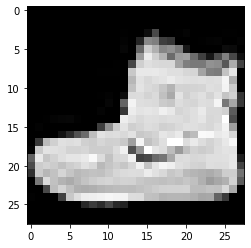

Reconstructed Train Image


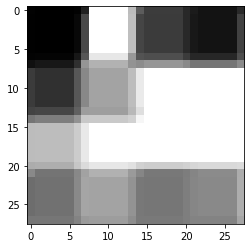

Actual Train Image


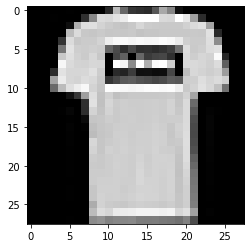

Reconstructed Train Image


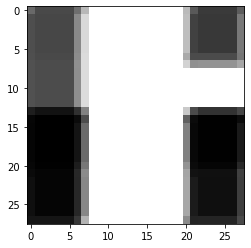

-------------------------------------
Actual Test Image


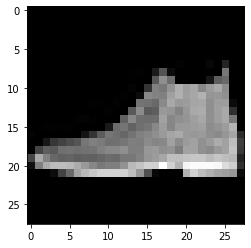

Reconstructed Test Image


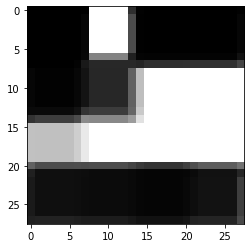

Actual Test Image


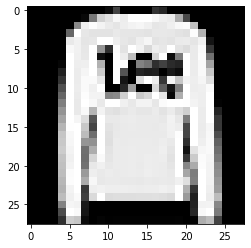

Reconstructed Test Image


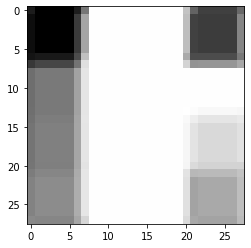

In [9]:
# Graphing the actual images to see reconstructed images

from matplotlib import pyplot

for i in range(2):
    print("Actual Train Image")
    pyplot.imshow(x_train[i][:, :, 0], cmap = pyplot.get_cmap('gray'))
    pyplot.show()
    print("Reconstructed Train Image")
    pyplot.imshow(train_pred[i][:, :, 0], cmap = pyplot.get_cmap('gray'))
    pyplot.show()
    
print("-------------------------------------")

for i in range(2):
    print("Actual Test Image")
    pyplot.imshow(x_test[i][:, :, 0], cmap = pyplot.get_cmap('gray'))
    pyplot.show()
    print("Reconstructed Test Image")
    pyplot.imshow(test_pred[i][:, :, 0], cmap = pyplot.get_cmap('gray'))
    pyplot.show()

This is interesting. There is a slight difference still shown in the reconstructed image of the short sleeve shirt and the long sleeve shirt, i.e. they can still be distinguished. Also, shoes and shirts can be distinguished as well, despite the feature map not looking anything like the item.

### Visualize Encoder Embeddings and Compare to TSNE

In [10]:
# get the first 5 training set encoder embeddings and labels
autoencoder_x_train = np.array(encoder(x_train[:50]))
y_train =  y_train[:50]

# get the first 5 test set encoder embeddings and labels
autoencoder_x_test = np.array(encoder(x_test[:50]))
y_test = y_test[:50]

In [12]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# flatten each 28x28 image to 784 length
train_flat = []
for i in range(len(x_train)):
    train_flat += [x_train[i].flatten()]
# reduce the training set from 784 to 50 features using PCA (recommended in TSNE documentation)
train_pca = PCA(n_components = 50)
train_pca = train_pca.fit_transform(train_flat)
# use TSNE to reduce to vector of length 2
train_embedded = TSNE(n_components = 2).fit_transform(train_pca)


# flatten each 28x28 image to 784 length
test_flat = []
for i in range(len(x_test)):
    test_flat += [x_test[i].flatten()]
# reduce the test set from 784 to 50 features using PCA (recommended in TSNE documentation)
test_pca = PCA(n_components = 50)
test_pca = test_pca.fit_transform(test_flat)
# use TSNE to reduce to vector of length 2
test_embedded = TSNE(n_components = 2).fit_transform(test_pca)

In [13]:
# get the first 5 items from train and test embeddings to compare to autoencoder
tsne_x_train = train_embedded[:50]
tsne_x_test = test_embedded[:50]

Autoencoder Encoder Embeddings (Training)


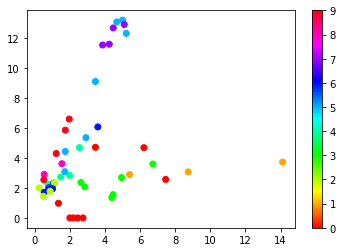

TSNE Embeddings (Training)


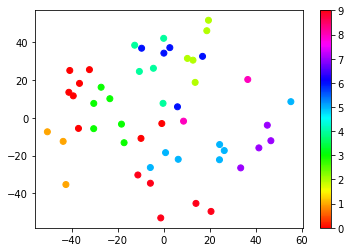

In [14]:
print("Autoencoder Encoder Embeddings (Training)")
pyplot.scatter(autoencoder_x_train[:,0], autoencoder_x_train[:,1], c = list(y_train), cmap = 'hsv')
pyplot.colorbar()
pyplot.show()
print("TSNE Embeddings (Training)")
pyplot.scatter(tsne_x_train[:,0], tsne_x_train[:,1], c = list(y_train), cmap = 'hsv')
pyplot.colorbar()
pyplot.show()

Autoencoder Encoder Embeddings (Test)


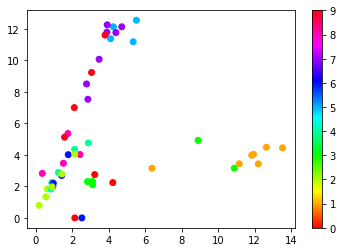

TSNE Embeddings (Test)


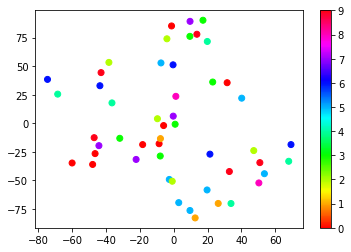

In [15]:
print("Autoencoder Encoder Embeddings (Test)")
pyplot.scatter(autoencoder_x_test[:,0], autoencoder_x_test[:,1], c = list(y_test), cmap = 'hsv')
pyplot.colorbar()
pyplot.show()
print("TSNE Embeddings (Test)")
pyplot.scatter(tsne_x_test[:,0], tsne_x_test[:,1], c = list(y_train), cmap = 'hsv')
pyplot.colorbar()
pyplot.show()

### Expectation vs. Reality

EXPECTATION: I expect to see that the encoded images are well separated due to the features extracted from the convolution layers. Each image has difference levels of grey and the vector of length 2 produced by the encoder should represent each class well, if the image features are extracted properly. The comparison is being made to the TSNE dimensionality reduction algorithm as recommended, but the TSNE documentation suggests to use PCA (or other dimensionality reduction algorithm) to reduce dimensions to around 50 before using TSNE. I would expect both, the autoencoder and TSNE embeddings to separate the classes properly, but they both won't be the same graphs if graphed on the same plot.

REALITY: The autoencoder encoder embeddings did not work very well in clustering similar items together, and it did not use the range of values in the x-y plane properly. Most embeddings lie on linear lines, causing the clustering to not be useful. This might be because the encoder in the autoencoder function isn't doing a good job extracting features. It could be improved by using more convolutional layers, or doing more pooling and normalization. As for TSNE, it is using the x-y plane well and it is attempting to split the classes, but it is still not doing well in splitting the classes. This does make sense because it is difficult to show a 28x28 (784) pixel image in 2 dimensions. 